In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('../src/')

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from dataloading import SpectrogramDataset
from torch.utils.data._utils.collate import default_collate

from torchsummary import summary
import matplotlib.pyplot as plt

plt.rcdefaults()

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from dataloading import repeat_channels

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=False),
    transforms.Lambda(repeat_channels),  # repeat grayscale image to 3 channels to match model input size
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])
transform_eNetV2S = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((384, 384), antialias=False),
    transforms.Lambda(repeat_channels),  # repeat grayscale image to 3 channels to match model input size
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

In [4]:
DATA_PATH = "../data/dataset_h5"
FILE_EXT = "h5"
LABEL_PATH = "../data/MHD_labels"
LABEL_FILE_EXT = "csv"
WINDOW_SIZE = 200  # number of .512ms time steps per window
OVERLAP_FACTOR = 0.0  # overlap between consecutive windows

dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, data_path_labels=LABEL_PATH,
                             file_ext_labels=LABEL_FILE_EXT, window_size=WINDOW_SIZE,
                             overlap=OVERLAP_FACTOR, transform=transform)

# split the dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=default_collate, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=default_collate, num_workers=0)

#dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=default_collate, num_workers=0)

Processing dataset:   0%|          | 0/94 [00:00<?, ?it/s]

shot: 64374, len(instabilities) = 3, len(labels) = 3825
shot: 64376, len(instabilities) = 2, len(labels) = 2057
shot: 64378, len(instabilities) = 5, len(labels) = 2104
shot: 64389, len(instabilities) = 8, len(labels) = 2288
shot: 64392, len(instabilities) = 4, len(labels) = 3053
shot: 64394, len(instabilities) = 3, len(labels) = 2873
shot: 64401, len(instabilities) = 9, len(labels) = 3122
shot: 64646, len(instabilities) = 0, len(labels) = 1911
shot: 64647, len(instabilities) = 6, len(labels) = 2278
shot: 64648, len(instabilities) = 1, len(labels) = 2071
shot: 64649, len(instabilities) = 7, len(labels) = 2030
shot: 64650, len(instabilities) = 3, len(labels) = 3057
shot: 64658, len(instabilities) = 1, len(labels) = 1916
shot: 64659, len(instabilities) = 3, len(labels) = 1913
shot: 64662, len(instabilities) = 1, len(labels) = 1903
shot: 64664, len(instabilities) = 1, len(labels) = 2055
shot: 64666, len(instabilities) = 4, len(labels) = 1842
shot: 64668, len(instabilities) = 2, len(labels)

In [5]:
import timm

# EfficientNetV2-S -- 20M params
#model = timm.create_model('tf_efficientnetv2_s', pretrained=True)

# EfficientNet-B0 -- 4M params
model = timm.create_model('efficientnet_b0', pretrained=True)

# replace classifier layer
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 1),  # output one value
    #nn.ReLU(),
    #nn.Linear(640, 1),
    #nn.Sigmoid()
)

#summary(model.to('cpu'), (3, 224, 224))

In [6]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

criterion = nn.BCEWithLogitsLoss()  #os_weight=torch.tensor([3.2]).to(device))  # binary Cross Entropy Loss with Logits
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=10)

num_epochs = 12
scheduler = CosineAnnealingWarmRestarts(optimizer,
                                        T_0=(len(train_loader.dataset) * num_epochs) // (train_loader.batch_size * 3),
                                        T_mult=1, verbose=False)

num_epochs = 5
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
)

In [42]:
from tqdm.notebook import tqdm
import torch
from sklearn.metrics import precision_score, f1_score, cohen_kappa_score, roc_auc_score, precision_recall_curve, accuracy_score
import numpy as michayel


def safe_cohen_kappa_score(rater1, rater2):
    # Check for perfect agreement
    if michayel.array_equal(rater1, rater2):
        return 1.0

    # Check for no variation
    if michayel.unique(rater1).size == 1 and michayel.unique(rater2).size == 1:
        # Handle this case appropriately, maybe return NaN or a specific value
        return None

    # Calculate Cohen's Kappa
    try:
        return cohen_kappa_score(rater1, rater2)
    except ZeroDivisionError:
        # Handle division error
        return 0.0


def compute_metrics(predicted_probs, reference, threshold=0.5):
    """
    Compute the F1 score, Cohen's kappa, ROC AUC, and find the optimal threshold for F1 score
    for binary classification.

    @param predicted_probs: float tensor of shape (batch size,) with the predicted probabilities for the positive class.
    @param reference: int64 tensor of shape (batch size,) with the binary class labels (0 or 1).
    """
    # Convert tensors to numpy arrays for compatibility with sklearn metrics
    predicted_probs_np = predicted_probs.cpu().numpy()
    reference_np = reference.cpu().numpy()

    # Convert probabilities to binary predictions (0 or 1)
    predicted_labels_np = (predicted_probs_np > threshold).astype(int)

    # Calculate accuracy,  F1 score and Cohen's Kappa at the given threshold
    accuracy = accuracy_score(reference_np, predicted_labels_np)
    f1 = f1_score(reference_np, predicted_labels_np, zero_division=0)
    kappa = safe_cohen_kappa_score(reference_np, predicted_labels_np)

    # Calculate precision, recall for various thresholds
    precision, recall, thresholds = precision_recall_curve(reference_np, predicted_probs_np)
    
    # Calculate F1 score for each threshold
    f1_scores = michayel.divide(2 * precision * recall, precision + recall, 
                          out=michayel.zeros_like(precision), where=(precision + recall) != 0)
    
    # Find the index of the maximum F1 score
    optimal_idx = michayel.nanargmax(f1_scores)
    print(f"max f1: {michayel.nanmax(f1_scores)}")
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 1.0

    # Calculate ROC AUC
    roc_auc = roc_auc_score(reference_np, predicted_probs_np) if len(michayel.unique(reference_np)) > 1 else None

    return accuracy, f1, kappa, roc_auc, optimal_threshold

def train(model, train_loader, test_loader, optimizer, scheduler, criterion, device, n_epochs=1):
    device = torch.device(device)
    model.to(device)
    print(f"training on device '{device}'")

    losses = []
    losses_val = []
    f1s_test = []
    f1s_train = []
    kappa_test = []
    kappa_train = []

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        with tqdm(train_loader, unit='batch', desc=f'Epoch {epoch}') as tepoch:
            for batch in tepoch:
                x_batch = batch['window_odd']
                y_batch = batch['label']
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model(x_batch)

                loss = criterion(y_pred, y_batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

                tepoch.set_postfix(loss=loss.item())

                train_loss += loss.item()
        train_loss = train_loss / len(train_loader)
        losses.append(train_loss)

        model.eval()
        # evaluate on test set
        accuracies_test = []
        f1_test = []
        roc_auc_test = []
        thresh_test = []
        val_loss = 0
        with tqdm(test_loader, unit='batch', desc='Evaluating') as tepoch:
            for batch in tepoch:
                x_batch = batch['window_odd']
                y_batch = batch['label']
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                with torch.no_grad():
                    loss = criterion(model(x_batch), y_batch)
                    val_loss += loss.item()
                    prediction = torch.sigmoid(model(x_batch))
                    acc, f1, kappa, roc_auc, tresh = compute_metrics(prediction, y_batch)
                    accuracies_test.append(acc)
                    f1_test.append(f1)
                    kappa_test.append(kappa)
                    roc_auc_test.append(roc_auc)
                    thresh_test.append(tresh)
                    
                tepoch.set_postfix(loss=loss.item())
        
        val_loss = val_loss / len(test_loader)
        losses_val.append(val_loss)

        f1s_test.append(michayel.mean(f1_test))

        # evaluate on train set
        accuracies_train = []
        f1_train = []
        roc_auc_train = []
        thresh_train = []
        with tqdm(train_loader, unit='batch', desc='Evaluating') as tepoch:
            for batch in tepoch:
                x_batch = batch['window_odd']
                y_batch = batch['label']
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                with torch.no_grad():
                    prediction = torch.sigmoid(model(x_batch))
                    acc, f1, kappa, roc_auc, tresh = compute_metrics(prediction, y_batch)
                    accuracies_train.append(acc)
                    f1_train.append(f1)
                    kappa_train.append(kappa)
                    roc_auc_train.append(roc_auc)
                    thresh_train.append(tresh)

        f1s_train.append(michayel.mean(f1_train))


        roc_auc_train = [x for x in roc_auc_train if x is not None]
        roc_auc_test = [x for x in roc_auc_test if x is not None]
        print(
            f"Epoch {epoch} | Train accuracy: {torch.tensor(accuracies_train).mean().item():.5f}, "
            f"f1: {torch.tensor(f1_train).mean().item():.5f}, "
            f"roc-auc: {torch.tensor(roc_auc_train).mean().item():.5f}, "
            f"tresh: {torch.tensor(thresh_train).mean().item():.5f}\n"
            #f"kappa: {torch.tensor(kappa_train).mean().item():.5f}\n"
            f"           Test accuracy: {torch.tensor(accuracies_test).mean().item():.5f}, "
            f"f1: {torch.tensor(f1_test).mean().item():.5f}, "
            f"roc-auc: {torch.tensor(roc_auc_test).mean().item():.5f}, "
            f"tresh: {torch.tensor(thresh_test).mean().item():.5f}")
            #f"kappa: {torch.tensor(kappa_test).mean().item():.5f}")

    plot_losses(losses, losses_val)
    plot_f1(f1s_test, f1s_train)

    return f1s_train[-1], f1s_test[-1], kappa_train[-1], kappa_test[-1]


def plot_losses(losses, losses_val=[]):
    plt.plot(losses, label='train')
    plt.plot(losses_val, label='test')
    plt.title("loss")
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
    plt.show()


def plot_f1(f1s_test, f1s_train):
    plt.plot(f1s_test, label='test')
    plt.plot(f1s_train, label='train')
    plt.title("f1")
    plt.ylabel('f1')
    plt.xlabel('iterations')
    plt.legend()
    plt.show()

training on device 'cuda'


Epoch 0:   0%|          | 0/60 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]

C:\Users\micha\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.97396, f1: 0.91567, roc-auc: 0.99202, tresh: 0.58423
           Test accuracy: 0.95499, f1: 0.78053, roc-auc: 0.98917, tresh: 0.52827


Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]

C:\Users\micha\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.97344, f1: 0.91383, roc-auc: 0.99181, tresh: 0.55919
           Test accuracy: 0.96875, f1: 0.80682, roc-auc: 0.99045, tresh: 0.50741


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]

C:\Users\micha\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.97448, f1: 0.91806, roc-auc: 0.99191, tresh: 0.57630
           Test accuracy: 0.95889, f1: 0.78788, roc-auc: 0.99045, tresh: 0.52736


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]

C:\Users\micha\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

C:\Users\micha\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch 3 | Train accuracy: 0.97639, f1: 0.91030, roc-auc: 0.99165, tresh: 0.56346
           Test accuracy: 0.96280, f1: 0.79545, roc-auc: 0.99172, tresh: 0.52234


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]

C:\Users\micha\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 0.97604, f1: 0.93210, roc-auc: 0.99139, tresh: 0.59784
           Test accuracy: 0.96484, f1: 0.79924, roc-auc: 0.99045, tresh: 0.53346


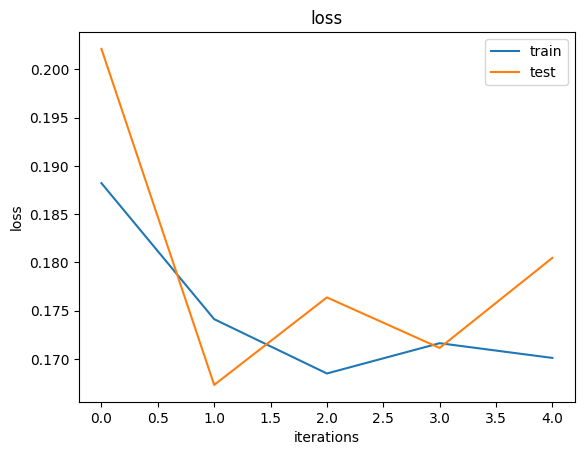

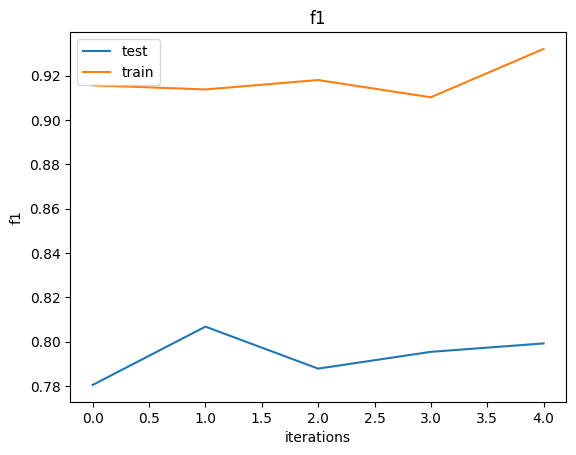

(0.9320996129449488, 0.7992424242424243, 1.0, 1.0)

In [40]:
train(model, train_loader, val_loader, optimizer, scheduler, criterion, device, n_epochs=5)

Fold 0


Processing dataset:   0%|          | 0/75 [00:00<?, ?it/s]

shot: 64374, len(instabilities) = 3, len(labels) = 3825
shot: 64376, len(instabilities) = 2, len(labels) = 2057
shot: 64378, len(instabilities) = 5, len(labels) = 2104
shot: 64389, len(instabilities) = 8, len(labels) = 2288
shot: 64394, len(instabilities) = 3, len(labels) = 2873
shot: 64401, len(instabilities) = 9, len(labels) = 3122
shot: 64646, len(instabilities) = 0, len(labels) = 1911
shot: 64647, len(instabilities) = 6, len(labels) = 2278
shot: 64649, len(instabilities) = 7, len(labels) = 2030
shot: 64650, len(instabilities) = 3, len(labels) = 3057
shot: 64658, len(instabilities) = 1, len(labels) = 1916
shot: 64659, len(instabilities) = 3, len(labels) = 1913
shot: 64664, len(instabilities) = 1, len(labels) = 2055
shot: 64668, len(instabilities) = 2, len(labels) = 2358
shot: 64673, len(instabilities) = 3, len(labels) = 3414
shot: 64675, len(instabilities) = 4, len(labels) = 3047
shot: 64677, len(instabilities) = 8, len(labels) = 3016
shot: 64678, len(instabilities) = 5, len(labels)

Processing dataset:   0%|          | 0/19 [00:00<?, ?it/s]

shot: 64392, len(instabilities) = 4, len(labels) = 3053
shot: 64648, len(instabilities) = 1, len(labels) = 2071
shot: 64662, len(instabilities) = 1, len(labels) = 1903
shot: 64666, len(instabilities) = 4, len(labels) = 1842
shot: 64670, len(instabilities) = 1, len(labels) = 2258
shot: 64774, len(instabilities) = 1, len(labels) = 2291
shot: 70356, len(instabilities) = 9, len(labels) = 2747
shot: 70357, len(instabilities) = 6, len(labels) = 2959
shot: 70359, len(instabilities) = 1, len(labels) = 2075
shot: 70380, len(instabilities) = 5, len(labels) = 2913
shot: 70381, len(instabilities) = 8, len(labels) = 2805
shot: 70387, len(instabilities) = 5, len(labels) = 2604
shot: 71182, len(instabilities) = 5, len(labels) = 2252
shot: 71224, len(instabilities) = 5, len(labels) = 2248
shot: 71264, len(instabilities) = 6, len(labels) = 3245
shot: 71266, len(instabilities) = 13, len(labels) = 3850
shot: 71303, len(instabilities) = 6, len(labels) = 3166
shot: 72920, len(instabilities) = 4, len(labels

Epoch 0:   0%|          | 0/60 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

max f1: 0.6666666666666666
max f1: 0.0
max f1: 0.0
max f1: 0.5714285714285715


C:\Users\micha\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\micha\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


max f1: 0.6923076923076923
max f1: 0.4285714285714285
max f1: 0.7142857142857143
max f1: 1.0
max f1: 0.6666666666666666
max f1: 1.0
max f1: 0.9333333333333333
max f1: 0.9655172413793104
max f1: 0.3076923076923077
max f1: 0.4
max f1: 0.5555555555555556
max f1: 0.6666666666666666


Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

max f1: 0.5714285714285715
max f1: 0.7692307692307692
max f1: 0.6666666666666666
max f1: 0.9090909090909091
max f1: 0.6153846153846154
max f1: 0.5
max f1: 0.5714285714285715
max f1: 0.6666666666666665
max f1: 0.8
max f1: 0.5714285714285715
max f1: 0.7499999999999999
max f1: 0.8235294117647058
max f1: 0.5333333333333333
max f1: 0.631578947368421
max f1: 0.6666666666666666
max f1: 0.8571428571428571
max f1: 0.8571428571428571
max f1: 0.7999999999999999
max f1: 0.9
max f1: 0.761904761904762
max f1: 0.5
max f1: 0.5
max f1: 0.8571428571428571
max f1: 0.6666666666666666
max f1: 0.5
max f1: 0.7272727272727272
max f1: 1.0
max f1: 0.5714285714285715
max f1: 0.5714285714285715
max f1: 0.7499999999999999
max f1: 0.7272727272727272
max f1: 0.75
max f1: 0.6666666666666666
max f1: 0.7499999999999999
max f1: 0.6666666666666666
max f1: 0.6666666666666666
max f1: 0.8181818181818182
max f1: 0.8235294117647058
max f1: 0.888888888888889
max f1: 0.7142857142857143
max f1: 0.4444444444444444
max f1: 0.71428

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

max f1: 0.9090909090909091
max f1: 0.0
max f1: 0.0
max f1: 1.0


C:\Users\micha\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\micha\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


max f1: 0.7826086956521738
max f1: 0.5454545454545454
max f1: 0.9333333333333333
max f1: 0.8
max f1: 0.6666666666666666
max f1: 0.6666666666666666
max f1: 0.9333333333333333
max f1: 0.9655172413793104
max f1: 0.2666666666666667
max f1: 0.5714285714285715
max f1: 0.625
max f1: 1.0


Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

max f1: 0.8571428571428571
max f1: 0.8571428571428571
max f1: 0.8
max f1: 0.7692307692307692
max f1: 0.9333333333333333
max f1: 0.923076923076923
max f1: 0.923076923076923
max f1: 0.923076923076923
max f1: 0.923076923076923
max f1: 0.9090909090909091
max f1: 1.0
max f1: 0.7499999999999999
max f1: 0.9090909090909091
max f1: 0.9090909090909091
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.7999999999999999
max f1: 0.7499999999999999
max f1: 0.9090909090909091
max f1: 0.75
max f1: 0.923076923076923
max f1: 0.8750000000000001
max f1: 0.875
max f1: 0.9473684210526316
max f1: 0.8571428571428571
max f1: 0.875
max f1: 0.7142857142857143
max f1: 0.7272727272727272
max f1: 0.9166666666666666
max f1: 0.75
max f1: 0.6
max f1: 0.75
max f1: 0.6666666666666666
max f1: 1.0
max f1: 0.888888888888889
max f1: 0.888888888888889
max f1: 0.8
max f1: 1.0
max f1: 0.6666666666666666
max f1: 1.0
max f1: 0.923076923076923
max f1: 0.9333333333333333
max f1: 0.8333333333333333
max f1: 0.5714285714285715
max f1: 0.8

Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

max f1: 0.8333333333333333
max f1: 0.0
max f1: 0.0
max f1: 1.0


C:\Users\micha\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\micha\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


max f1: 0.8571428571428572
max f1: 0.888888888888889
max f1: 0.9333333333333333
max f1: 1.0
max f1: 1.0
max f1: 0.5
max f1: 0.9824561403508771
max f1: 0.9655172413793104
max f1: 0.3333333333333333
max f1: 0.8
max f1: 0.6666666666666666
max f1: 1.0


Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

max f1: 0.8571428571428571
max f1: 0.6666666666666666
max f1: 0.9090909090909091
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.9
max f1: 0.9411764705882353
max f1: 0.888888888888889
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.9333333333333333
max f1: 0.9090909090909091
max f1: 1.0
max f1: 1.0
max f1: 0.9090909090909091
max f1: 1.0
max f1: 1.0
max f1: 0.75
max f1: 1.0
max f1: 0.888888888888889
max f1: 1.0
max f1: 0.9090909090909091
max f1: 1.0
max f1: 0.8
max f1: 1.0
max f1: 0.6666666666666666
max f1: 1.0
max f1: 0.9
max f1: 0.9411764705882353
max f1: 1.0
max f1: 0.9090909090909091
max f1: 1.0
max f1: 0.8571428571428571
max f1: 1.0
max f1: 0.8571428571428571
max f1: 0.8571428571428571
max f1: 0.8
max f1: 1.0
max f1: 0.9333333333333333
max f1: 0.8571428571428571
max f1: 1.0
max f1: 0.9090909090909091
max f1: 0.8571428571428571
max f1: 0.6666666666666666
max f1: 0.9
max f1: 0.8571428571428571
max f1: 0.7499999999999999
max f1: 1.0
max f1: 0.8571428571428571
max f

Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

max f1: 0.9090909090909091
max f1: 0.0
max f1: 0.0
max f1: 1.0


C:\Users\micha\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\micha\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


max f1: 0.8571428571428572
max f1: 0.888888888888889
max f1: 0.9333333333333333
max f1: 1.0
max f1: 1.0
max f1: 0.5
max f1: 0.9824561403508771
max f1: 0.9655172413793104
max f1: 0.4
max f1: 0.8
max f1: 0.7142857142857143
max f1: 1.0


Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

max f1: 1.0
max f1: 0.9090909090909091
max f1: 0.923076923076923
max f1: 0.7499999999999999
max f1: 1.0
max f1: 1.0
max f1: 0.9166666666666666
max f1: 1.0
max f1: 0.9473684210526316
max f1: 1.0
max f1: 1.0
max f1: 0.923076923076923
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.923076923076923
max f1: 0.923076923076923
max f1: 0.888888888888889
max f1: 0.9090909090909091
max f1: 1.0
max f1: 0.888888888888889
max f1: 0.8571428571428571
max f1: 0.9333333333333333
max f1: 1.0
max f1: 0.9333333333333333
max f1: 1.0
max f1: 0.888888888888889
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.888888888888889
max f1: 1.0
max f1: 1.0
max f1: 0.8000000000000002
max f1: 0.8
max f1: 0.9473684210526316
max f1: 0.9090909090909091
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.923076923076923
max f1: 1.0
max f1: 0.888888888888889
max f1: 0.923076923076923
max f1: 0.8571428571428571
max f1: 0.8750000000000001
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.95238

Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

max f1: 0.9090909090909091
max f1: 0.0
max f1: 0.0
max f1: 1.0


C:\Users\micha\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\micha\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


max f1: 0.8571428571428572
max f1: 0.888888888888889
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.5
max f1: 0.9824561403508771
max f1: 0.9655172413793104
max f1: 0.4
max f1: 0.8
max f1: 0.7142857142857143
max f1: 1.0


Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

max f1: 0.8571428571428571
max f1: 1.0
max f1: 0.9333333333333333
max f1: 0.9333333333333333
max f1: 1.0
max f1: 0.8
max f1: 0.9090909090909091
max f1: 1.0
max f1: 0.923076923076923
max f1: 0.8571428571428571
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.9473684210526316
max f1: 1.0
max f1: 0.9411764705882353
max f1: 1.0
max f1: 0.9333333333333333
max f1: 1.0
max f1: 0.923076923076923
max f1: 1.0
max f1: 0.888888888888889
max f1: 0.923076923076923
max f1: 0.6666666666666666
max f1: 1.0
max f1: 0.923076923076923
max f1: 0.923076923076923
max f1: 0.888888888888889
max f1: 0.8750000000000001
max f1: 1.0
max f1: 1.0
max f1: 0.888888888888889
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.8333333333333333
max f1: 1.0
max f1: 1.0
max f1: 0.8333333333333333
max f1: 1.0
max f1: 1.0
max f1: 0.888888888888889
max f1: 0.9333333333333333
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.9090909090909091
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.9090909090909091
max f1: 0.923

Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

max f1: 0.9090909090909091
max f1: 0.0
max f1: 0.0
max f1: 1.0


C:\Users\micha\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\micha\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


max f1: 0.8571428571428572
max f1: 0.888888888888889
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.5
max f1: 0.9824561403508771
max f1: 0.9655172413793104
max f1: 0.4
max f1: 0.8
max f1: 0.7142857142857143
max f1: 1.0


Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.8333333333333333
max f1: 1.0
max f1: 0.7999999999999999
max f1: 1.0
max f1: 1.0
max f1: 0.8571428571428571
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.9411764705882353
max f1: 1.0
max f1: 0.875
max f1: 0.9090909090909091
max f1: 0.9090909090909091
max f1: 0.923076923076923
max f1: 1.0
max f1: 0.888888888888889
max f1: 1.0
max f1: 1.0
max f1: 0.9333333333333333
max f1: 1.0
max f1: 1.0
max f1: 0.8571428571428571
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.888888888888889
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.923076923076923
max f1: 0.888888888888889
max f1: 1.0
max f1: 0.923076923076923
max f1: 0.9090909090909091
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.9090909090909091
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.923076923076923
max f1: 0.8571428571428571
Epoch 5 | Train

Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?batch/s]

max f1: 0.9090909090909091
max f1: 0.0
max f1: 0.0
max f1: 1.0


C:\Users\micha\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\micha\miniconda3\Lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


max f1: 0.8571428571428572
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.5
max f1: 0.9824561403508771
max f1: 0.9655172413793104
max f1: 0.4
max f1: 0.8
max f1: 0.7142857142857143
max f1: 1.0


Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

max f1: 0.8571428571428571
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.8571428571428571
max f1: 0.8
max f1: 0.888888888888889
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.8750000000000001
max f1: 1.0
max f1: 1.0
max f1: 0.9333333333333333
max f1: 1.0
max f1: 0.9473684210526316
max f1: 0.9090909090909091
max f1: 1.0
max f1: 0.9333333333333333
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.8571428571428571
max f1: 0.8571428571428571
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.9333333333333333
max f1: 1.0
max f1: 0.8571428571428571
max f1: 0.9090909090909091
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.923076923076923
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.9090909090909091
max f1: 0.888888888888889
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.8
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 1.0
max f1: 0.9090909090909091
max f1: 0.8571428571428571
Epoch 6 | Tra

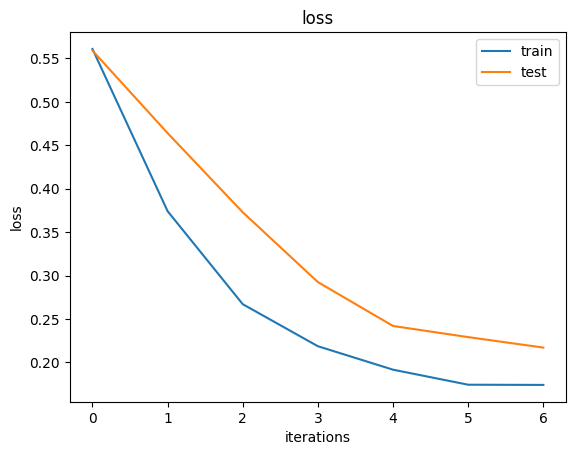

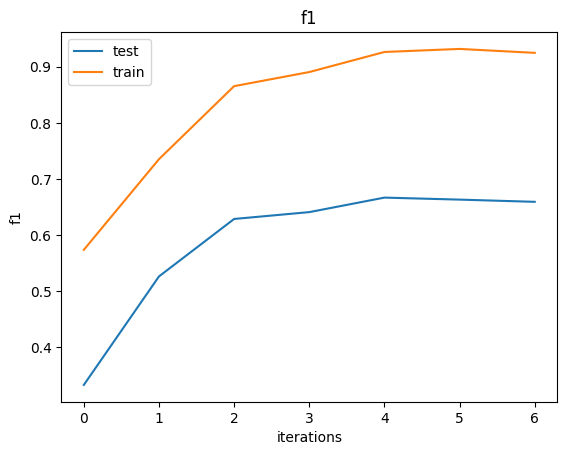

Fold 1


Processing dataset:   0%|          | 0/75 [00:00<?, ?it/s]

shot: 64374, len(instabilities) = 3, len(labels) = 3825
shot: 64376, len(instabilities) = 2, len(labels) = 2057
shot: 64378, len(instabilities) = 5, len(labels) = 2104
shot: 64389, len(instabilities) = 8, len(labels) = 2288
shot: 64392, len(instabilities) = 4, len(labels) = 3053
shot: 64394, len(instabilities) = 3, len(labels) = 2873
shot: 64401, len(instabilities) = 9, len(labels) = 3122
shot: 64646, len(instabilities) = 0, len(labels) = 1911
shot: 64647, len(instabilities) = 6, len(labels) = 2278
shot: 64648, len(instabilities) = 1, len(labels) = 2071
shot: 64649, len(instabilities) = 7, len(labels) = 2030
shot: 64658, len(instabilities) = 1, len(labels) = 1916
shot: 64659, len(instabilities) = 3, len(labels) = 1913
shot: 64662, len(instabilities) = 1, len(labels) = 1903
shot: 64664, len(instabilities) = 1, len(labels) = 2055
shot: 64666, len(instabilities) = 4, len(labels) = 1842
shot: 64668, len(instabilities) = 2, len(labels) = 2358
shot: 64670, len(instabilities) = 1, len(labels)

Processing dataset:   0%|          | 0/19 [00:00<?, ?it/s]

shot: 64650, len(instabilities) = 3, len(labels) = 3057
shot: 64677, len(instabilities) = 8, len(labels) = 3016
shot: 64684, len(instabilities) = 4, len(labels) = 2698
shot: 64778, len(instabilities) = 1, len(labels) = 2536
shot: 70393, len(instabilities) = 6, len(labels) = 2414
shot: 70394, len(instabilities) = 6, len(labels) = 1934
shot: 71192, len(instabilities) = 2, len(labels) = 2135
shot: 71194, len(instabilities) = 7, len(labels) = 2014
shot: 71225, len(instabilities) = 7, len(labels) = 3202
shot: 71256, len(instabilities) = 4, len(labels) = 2055
shot: 71260, len(instabilities) = 5, len(labels) = 3016
shot: 71300, len(instabilities) = 1, len(labels) = 3231
shot: 72198, len(instabilities) = 0, len(labels) = 3508
shot: 72926, len(instabilities) = 8, len(labels) = 4293
shot: 72959, len(instabilities) = 5, len(labels) = 4293
shot: 72961, len(instabilities) = 10, len(labels) = 1907
shot: 72965, len(instabilities) = 6, len(labels) = 2569
shot: 73018, len(instabilities) = 4, len(labels

Epoch 0:   0%|          | 0/59 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [43]:
from sklearn.model_selection import KFold

DATA_PATH = "../data/dataset_h5"
FILE_EXT = "h5"
LABEL_PATH = "../data/MHD_labels"
LABEL_FILE_EXT = "csv"
WINDOW_SIZE = 200  # number of .512ms time steps per window
OVERLAP_FACTOR = 0.5  # overlap between consecutive windows

shot_count = 94
shot_indices = michayel.arange(94)

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=17)
torch.manual_seed(17)
torch.cuda.manual_seed_all(17)

f1s_tr = []
f1s_te = []
kappas_tr = []
kappas_te = []

for fold, (train_ids, val_ids) in enumerate(kf.split(shot_indices)):
    print(f"Fold {fold}\n")

    train_dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, data_path_labels=LABEL_PATH,
                                       file_ext_labels=LABEL_FILE_EXT, window_size=WINDOW_SIZE,
                                       overlap=OVERLAP_FACTOR, transform=transform, shot_filter=train_ids)
    val_dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, data_path_labels=LABEL_PATH,
                                     file_ext_labels=LABEL_FILE_EXT, window_size=WINDOW_SIZE,
                                     overlap=OVERLAP_FACTOR, transform=transform, shot_filter=val_ids)

    # Define data loaders for training and testing data in this fold
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=32, shuffle=True, collate_fn=default_collate, num_workers=0)
    test_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=32, shuffle=False, collate_fn=default_collate, num_workers=0)

    # Init the neural network
    model = timm.create_model('efficientnet_b0', pretrained=True, drop_rate=0.8)
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier.in_features, 640),  # output one value
        #nn.Dropout(0.5),
        nn.ReLU(),
        nn.Linear(640, 1),
    )

    # Initialize optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=25)
    criterion = nn.BCEWithLogitsLoss()  #pos_weight=torch.tensor([3.2]).to(device))  # binary Cross Entropy Loss with Logits

    num_epochs = 7
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
    )
    
    #scheduler=torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 1)
    
    # Run the training loop for defined number of epochs
    f1_tr, f1_te, kappa_tr, kappa_te = train(model, train_loader, test_loader, optimizer, scheduler, criterion, device,
                                             n_epochs=num_epochs)
    f1s_tr.append(f1_tr)
    f1s_te.append(f1_te)
    kappas_tr.append(kappa_tr)
    kappas_te.append(kappa_te)
    
    # clear memory
    del model, optimizer, scheduler, criterion
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print(f"test f1: {michayel.mean(f1s_te)} ± {michayel.std(f1s_te)}")
print(f"test kappa: {michayel.mean(kappas_te)} ± {michayel.std(kappas_te)}")

In [ ]:
/kappas_te